## Import Libraries & Initiate Spark Session

In [26]:
# import sys
# !{sys.executable} -m pip install plotly

In [27]:
import os
import findspark
findspark.init()

In [28]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext

from pyspark.sql.types import * 
from pyspark.sql.functions import *

import pandas as pd
from handyspark import * 

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.mllib.stat import Statistics
# from pyspark.sql.functions import udf
# import pyspark.sql.functions as F
# from pyspark.sql.functions import col, asc,desc
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler,StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix


spark=SparkSession.builder \
.master ("local[*]")\
.appName("miniproject")\
.getOrCreate()
sc=spark.sparkContext
sqlContext=SQLContext(sc)

C:\Apps\spark-3.3.0-bin-hadoop3\python\pyspark\sql\context.py:112: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



In [29]:
bankdeposit_df = spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",";")\
 .csv("D:\\Libraries\\Documents\\BAN 5753\\Week 12\\XYZ_Bank_Deposit_Data_Classification.csv")
print("There are",bankdeposit_df.count(),"rows",len(bankdeposit_df.columns),
      "columns" ,"in the data.") 

There are 41188 rows 21 columns in the data.


In [30]:
bankdeposit_df.toPandas().head(10)

age          job  marital            education  default housing loan  \
0   56    housemaid  married             basic.4y       no      no   no   
1   57     services  married          high.school  unknown      no   no   
2   37     services  married          high.school       no     yes   no   
3   40       admin.  married             basic.6y       no      no   no   
4   56     services  married          high.school       no      no  yes   
5   45     services  married             basic.9y  unknown      no   no   
6   59       admin.  married  professional.course       no      no   no   
7   41  blue-collar  married              unknown  unknown      no   no   
8   24   technician   single  professional.course       no     yes   no   
9   25     services   single          high.school       no     yes   no   

     contact month day_of_week  ...  campaign  pdays  previous     poutcome  \
0  telephone   may         mon  ...         1    999         0  nonexistent   
1  telephone   may         mon  ...         1    999         0  nonexistent   
2  telephone   may         mon  ...         1    999         0  nonexistent   
3  telephone   may         mon  ...         1    999         0  nonexistent   
4  telephone   may         mon  ...         1    999         0  nonexistent   
5  telephone   may         mon  ...         1    999         0  nonexistent   
6  telephone   may         mon  ...         1    999         0  nonexistent   
7  telephone   may         mon  ...         1    999         0  nonexistent   
8  telephone   may         mon  ...         1    999         0  nonexistent   
9  telephone   may         mon  ...         1    999         0  nonexistent   

  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          1.1          93.994          -36.4      4.857       5191.0  no  
1          1.1          93.994          -36.4      4.857       5191.0  no  
2          1.1          93.994          -36.4      4.857       5191.0  no  
3          1.1          93.994          -36.4      4.857       5191.0  no  
4          1.1          93.994          -36.4      4.857       5191.0  no  
5          1.1          93.994          -36.4      4.857       5191.0  no  
6          1.1          93.994          -36.4      4.857       5191.0  no  
7          1.1          93.994          -36.4      4.857       5191.0  no  
8          1.1          93.994          -36.4      4.857       5191.0  no  
9          1.1          93.994          -36.4      4.857       5191.0  no  

[10 rows x 21 columns]

## Rename Columns That Contain "."

In [31]:
bankdeposit_df = bankdeposit_df.withColumnRenamed("emp.var.rate","emp_var_rate") \
    .withColumnRenamed("cons.price.idx","cons_price_idx") \
    .withColumnRenamed("cons.conf.idx","cons_conf_idx") \
    .withColumnRenamed("nr.employed","nr_employed")
bankdeposit_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)



## Encode Education To Ordinal Column

In [32]:
def udf_multiple(education):
      if (education == 'illiterate'):
        return 1
      elif (education == 'basic.4y'):
        return 2
      elif (education == 'basic.6y'):
        return 3
      elif (education == 'basic.9y'):
        return 4
      elif (education == 'high.school'):
        return 5
      elif (education == 'professional.course'):
        return 6
      elif (education == 'university.degree'):
        return 7
      else: return 0

education_group = udf(udf_multiple)
bankdeposit_df=bankdeposit_df.withColumn("education_group", education_group('education'))
bankdeposit_df=bankdeposit_df.withColumn("education_group",bankdeposit_df.education_group.cast('int'))

## Identify Categorical & Numerical Columns

In [33]:
String_columnList = [item[0] for item in bankdeposit_df.dtypes if item[1].startswith('string')]
Int_columnList = [item[0] for item in bankdeposit_df.dtypes if item[1].startswith('int')]
Double_columnList = [item[0] for item in bankdeposit_df.dtypes if item[1].startswith('double')]

Numerical = Int_columnList + Double_columnList
print("Numerical Columns:",Numerical)
print("String Columns:",String_columnList)

Numerical Columns: ['age', 'duration', 'campaign', 'pdays', 'previous', 'education_group', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']
String Columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


In [34]:
numeric_features = [t[0] for t in bankdeposit_df.dtypes if t[1] in ('int', 'double')]
bankdeposit_df.select(numeric_features).describe().toPandas().transpose()

0                    1                    2       3  \
summary          count                 mean               stddev     min   
age              41188    40.02406040594348   10.421249980934043      17   
duration         41188    258.2850101971448   259.27924883646455       0   
campaign         41188    2.567592502670681    2.770013542902331       1   
pdays            41188    962.4754540157328     186.910907344741       0   
previous         41188  0.17296299893172767  0.49490107983928927       0   
emp_var_rate     41188  0.08188550063178966     1.57095974051703    -3.4   
cons_price_idx   41188     93.5756643682899   0.5788400489540823  92.201   
cons_conf_idx    41188  -40.502600271918276    4.628197856174573   -50.8   
euribor3m        41188    3.621290812858533   1.7344474048512595   0.634   
nr_employed      41188    5167.035910943957    72.25152766826338  4963.6   
education_group  41188    4.944037098183937    1.909311601606554       0   

                      4  
summary             max  
age                  98  
duration           4918  
campaign             56  
pdays               999  
previous              7  
emp_var_rate        1.4  
cons_price_idx   94.767  
cons_conf_idx     -26.9  
euribor3m         5.045  
nr_employed      5228.1  
education_group       7

## Check For Null Values

In [35]:
null_df = bankdeposit_df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '') | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in bankdeposit_df.columns])

null_df.toPandas().head(1)

age  job  marital  education  default  housing  loan  contact  month  \
0    0    0        0          0        0        0     0        0      0   

   day_of_week  ...  pdays  previous  poutcome  emp_var_rate  cons_price_idx  \
0            0  ...      0         0         0             0               0   

   cons_conf_idx  euribor3m  nr_employed  y  education_group  
0              0          0            0  0                0  

[1 rows x 22 columns]

## Check For Class Imbalance

In [36]:
bankdeposit_df.groupby('y').count().toPandas()

y  count
0   no  36548
1  yes   4640

## Note: Many Visualizations Require Conversion To Pandas DF

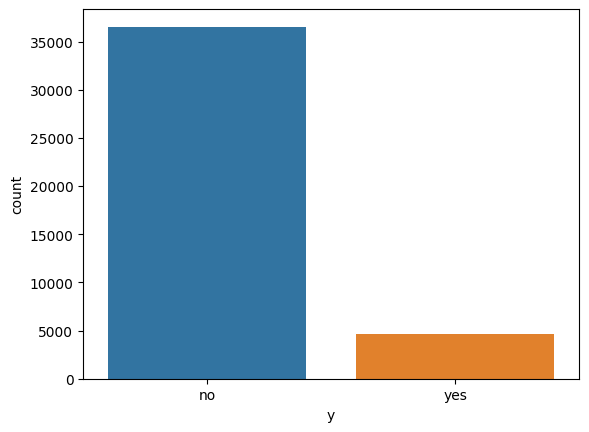

In [37]:
bank_df = bankdeposit_df.toPandas()
sns.countplot(data=bank_df, x='y')
plt.show()

## Check For Correlation Between Predictors

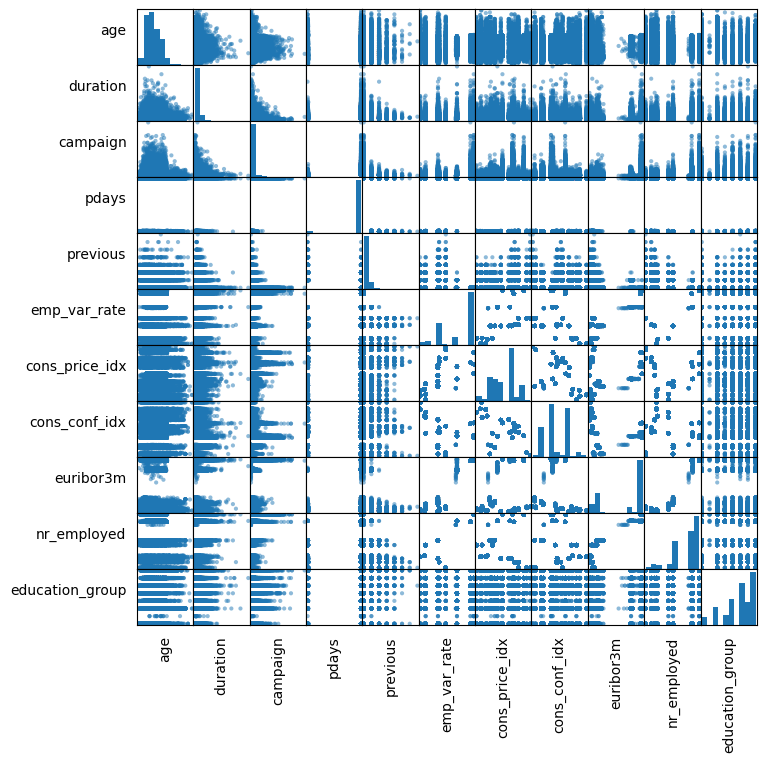

In [38]:
numeric_data = bankdeposit_df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

## Univariate Analysis

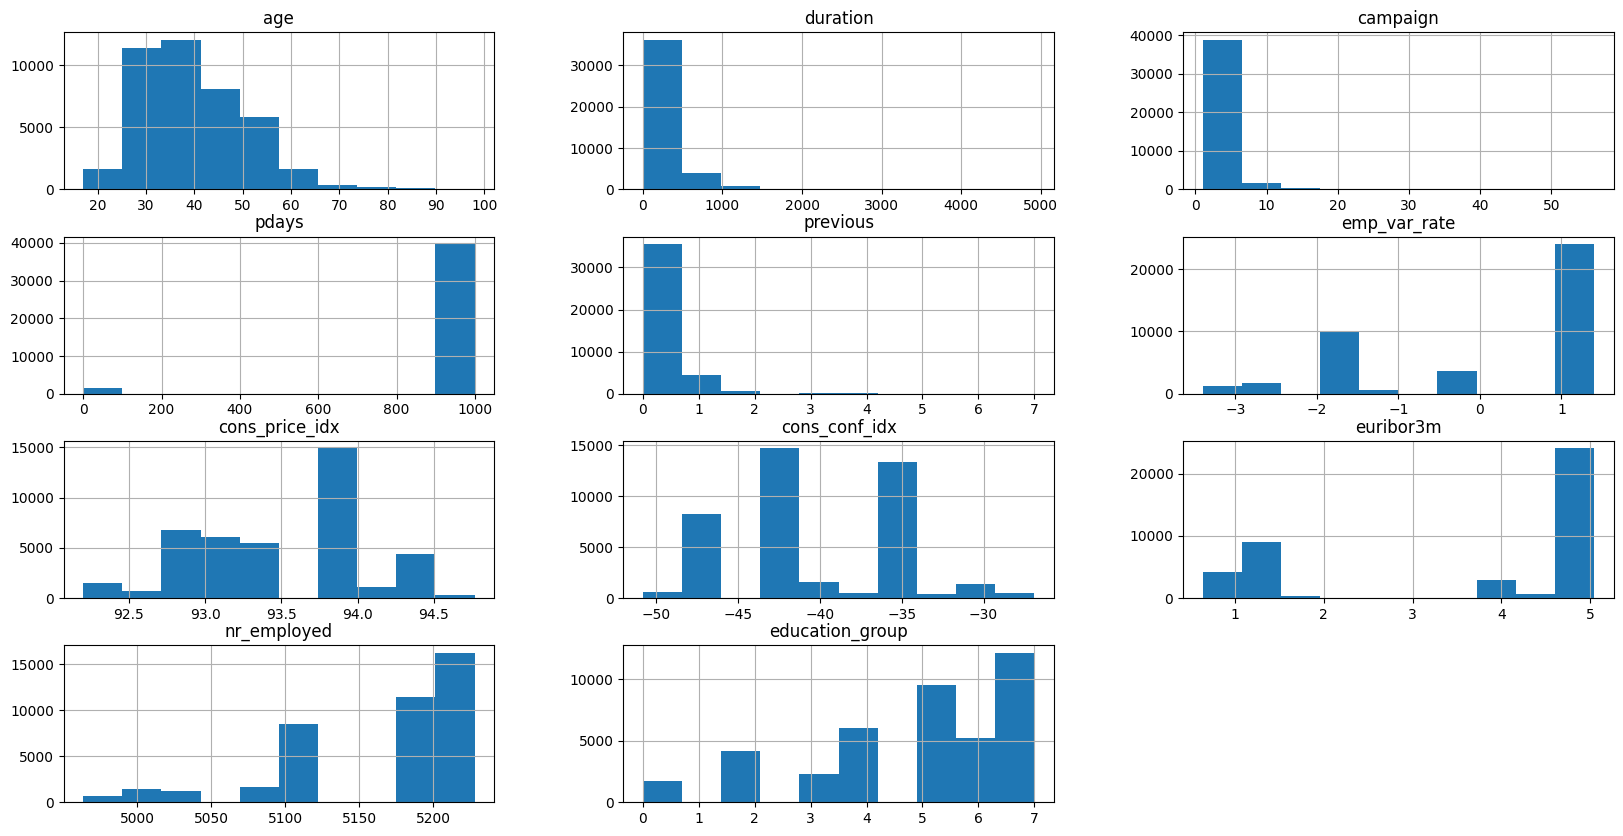

emp_var_rate  cons_price_idx  cons_conf_idx     euribor3m   nr_employed
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911
std        1.570960        0.578840       4.628198      1.734447     72.251528
min       -3.400000       92.201000     -50.800000      0.634000   4963.600000
25%       -1.800000       93.075000     -42.700000      1.344000   5099.100000
50%        1.100000       93.749000     -41.800000      4.857000   5191.000000
75%        1.400000       93.994000     -36.400000      4.961000   5228.100000
max        1.400000       94.767000     -26.900000      5.045000   5228.100000

In [39]:
numbers = bank_df.select_dtypes(['int64', 'float64']).columns.to_list()
bank_df.hist(figsize=(20,10))
plt.show()

display(bank_df[numbers].describe())

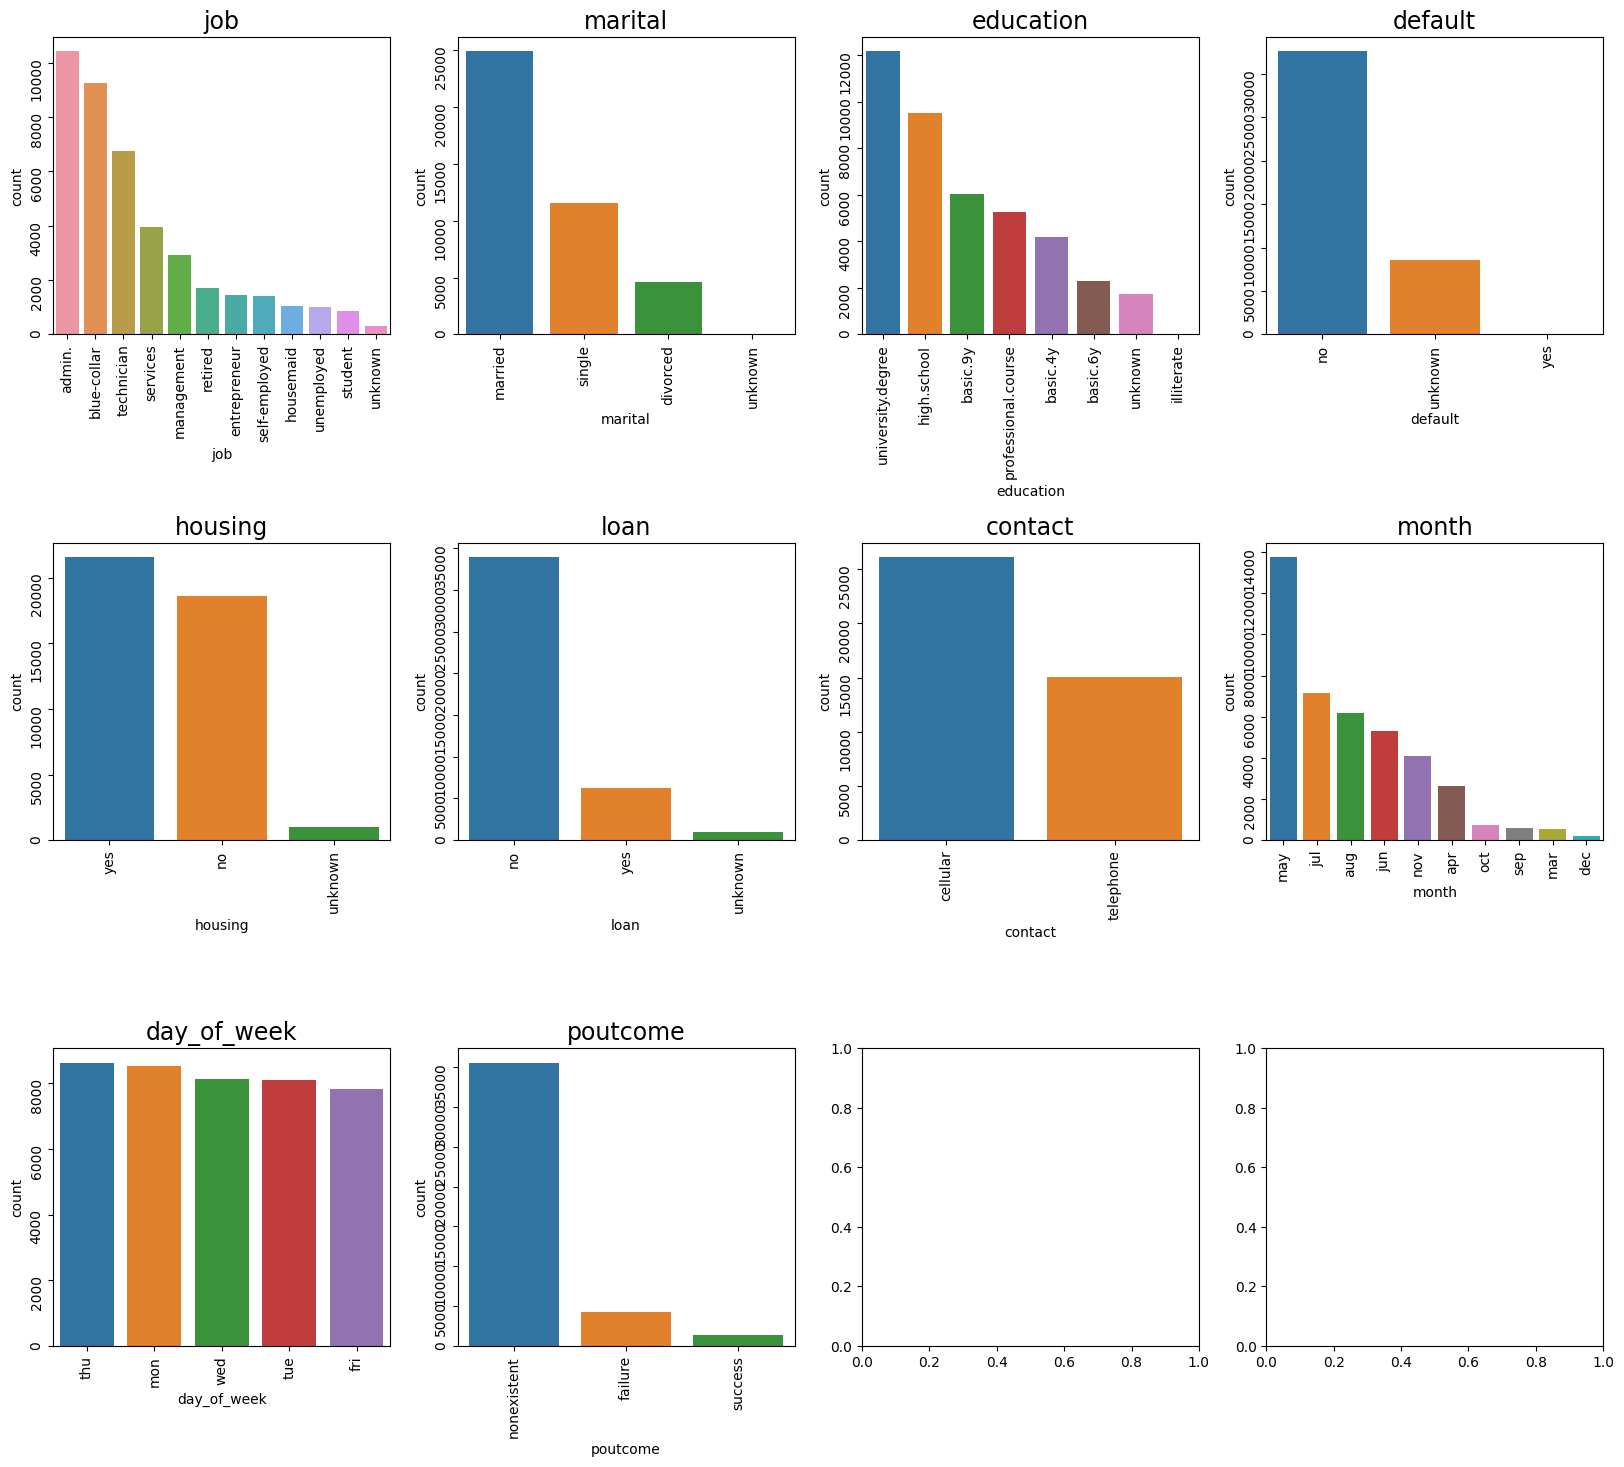

In [40]:
fig, ax = plt.subplots(3,4, figsize=(20,17))

cat = bank_df.select_dtypes('object').columns.to_list()
cat = cat[:-1]

ax = ax.ravel()
position = 0

for i in cat:
    
    order = bank_df[i].value_counts().index
    sns.countplot(data=bank_df, x=i, ax=ax[position], order=order)
    ax[position].tick_params(labelrotation=90)
    ax[position].set_title(i, fontdict={'fontsize':17})
    
    position += 1

plt.subplots_adjust(hspace=0.7)

plt.show()

C:\Users\lotr_\AppData\Local\Temp\ipykernel_24968\198833490.py:2: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\lotr_\AppData\Local\Temp\ipykernel_24968\198833490.py:7: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


C:\Users\lotr_\AppData\Local\Temp\ipykernel_24968\198833490.py:12: UserWarning:



`distplot` is a

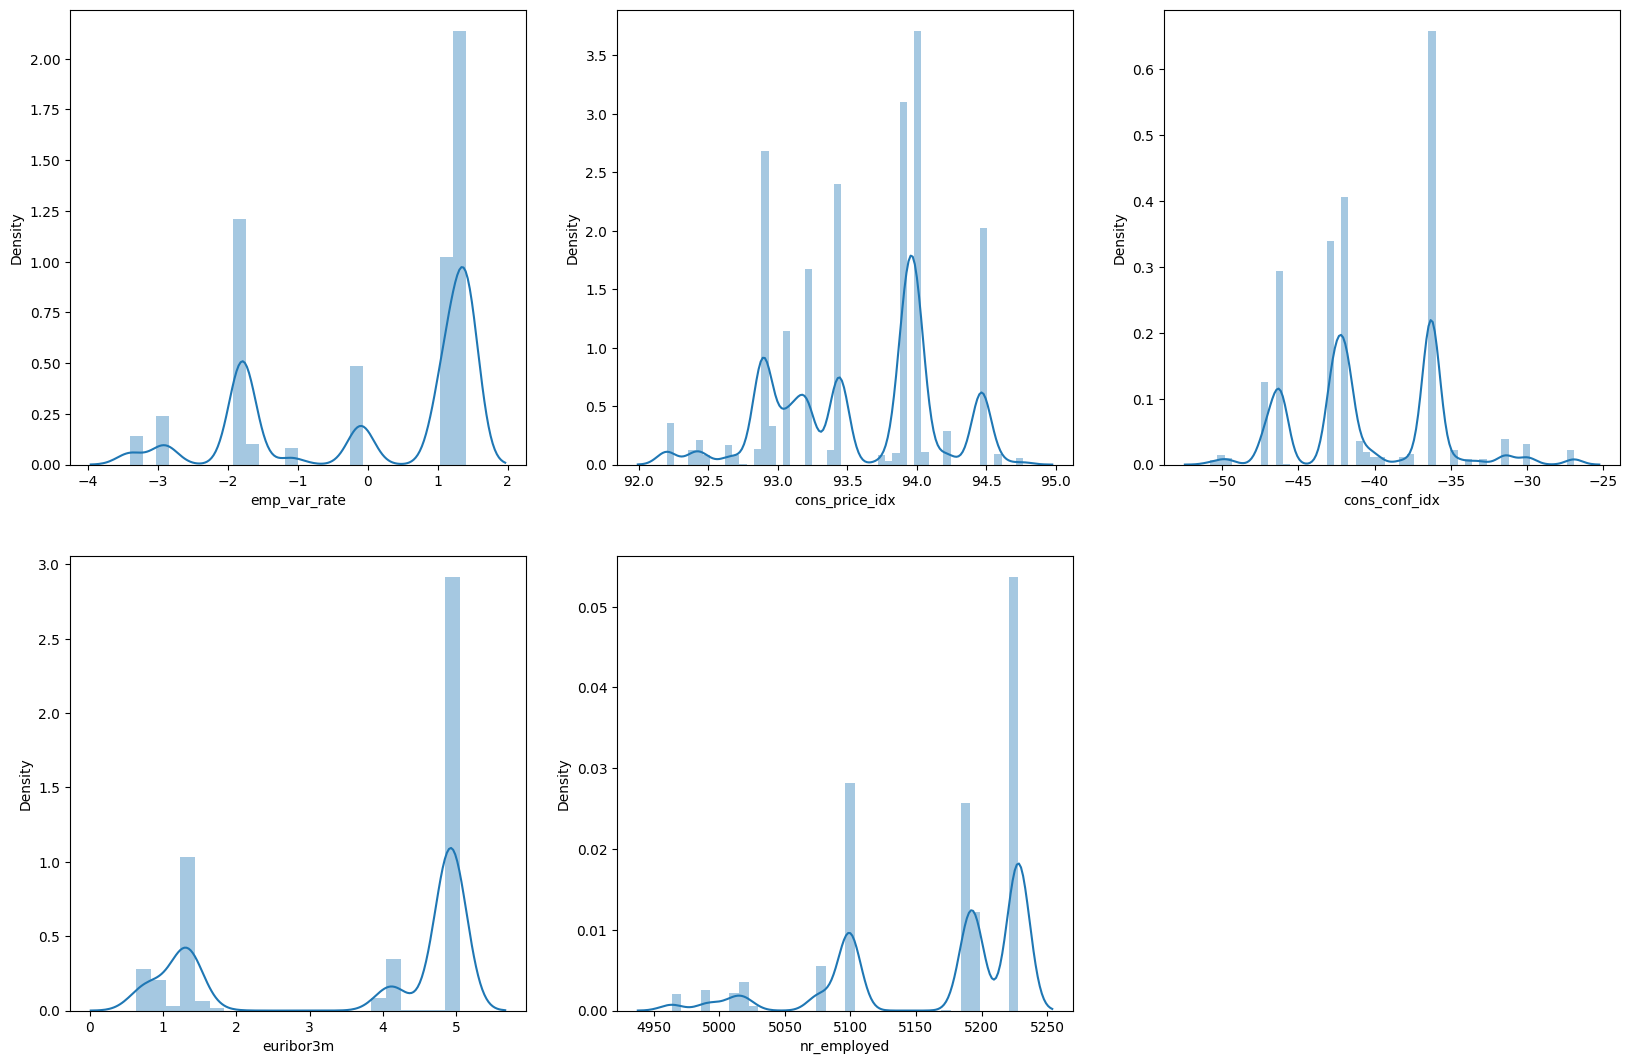

In [41]:
plt.subplot(231)
sns.distplot(bank_df['emp_var_rate'])
fig = plt.gcf()
fig.set_size_inches(20,13)

plt.subplot(232)
sns.distplot(bank_df['cons_price_idx'])
fig = plt.gcf()
fig.set_size_inches(20,13)

plt.subplot(233)
sns.distplot(bank_df['cons_conf_idx'])
fig = plt.gcf()
fig.set_size_inches(20,13)

plt.subplot(234)
sns.distplot(bank_df['euribor3m'])
fig = plt.gcf()
fig.set_size_inches(20,13)

plt.subplot(235)
sns.distplot(bank_df['nr_employed'])
fig = plt.gcf()
fig.set_size_inches(20,13)

## Bivariate Analysis 

In [42]:
import plotly.express as px

fig = px.box(bank_df, x="job", y="duration", color="y")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

In [43]:
fig = px.scatter(bank_df, x="campaign", y="duration", color="y")
fig.show()

<BarContainer object of 41188 artists>

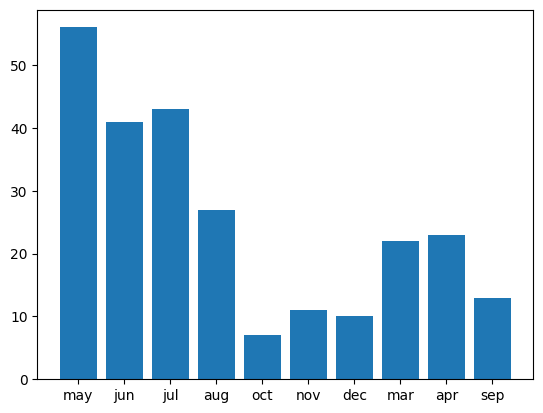

In [44]:
plt.bar(bank_df['month'], bank_df['campaign'])

<AxesSubplot: xlabel='cons_price_idx', ylabel='marital'>

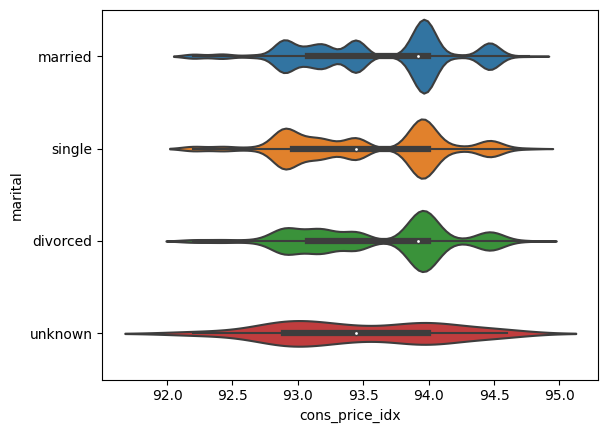

In [45]:
sns.violinplot( y=bank_df["marital"], x=bank_df["cons_price_idx"])

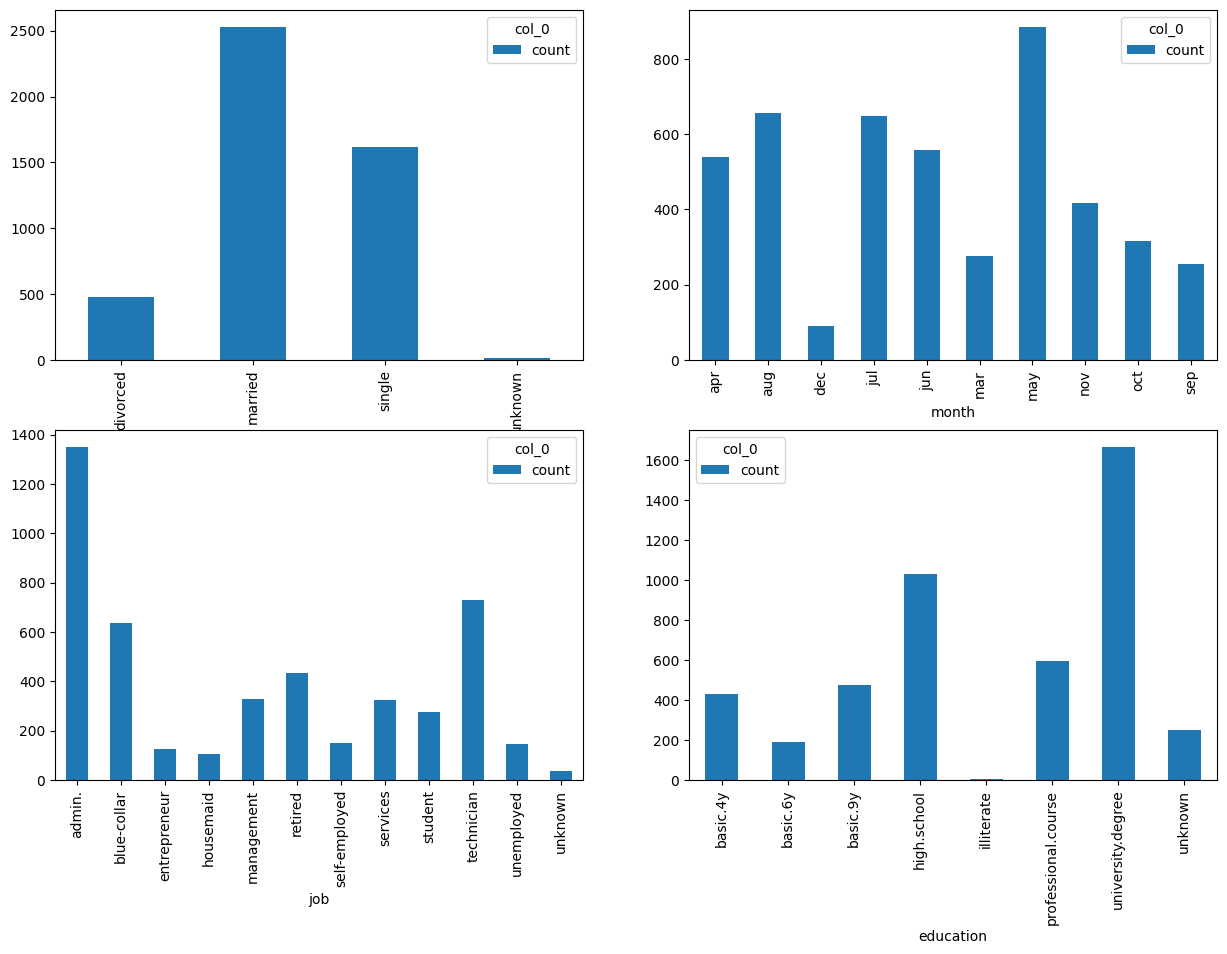

In [46]:
bank_yes = bank_df[bank_df['y']=='yes']

df1 = pd.crosstab(index = bank_yes["marital"],columns="count")    
df2 = pd.crosstab(index = bank_yes["month"],columns="count")  
df3= pd.crosstab(index = bank_yes["job"],columns="count") 
df4=pd.crosstab(index = bank_yes["education"],columns="count")

fig, axes = plt.subplots(nrows=2, ncols=2)
df1.plot.bar(ax=axes[0,0])
df2.plot.bar(ax=axes[0,1])
df3.plot.bar(ax=axes[1,0])
df4.plot.bar(ax=axes[1,1]) 
fig.set_size_inches(15,10)

## Prepare Inputs For Model

In [47]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome', 'month', 'day_of_week']
stages = []

for categoricalCol in categoricalColumns:    
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

In [48]:
label_stringIdx = StringIndexer(inputCol = 'y', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [49]:
cols = bankdeposit_df.columns
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(bankdeposit_df)
bankdeposit_df = pipelineModel.transform(bankdeposit_df)
selectedCols = ['label', 'features'] + cols
bankdeposit_df = bankdeposit_df.select(selectedCols)
bankdeposit_df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)
 |-- education_group: integer (nullable = true)



In [50]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol = 'features', outputCol = 'scaledFeatures')
scaler_model = scaler.fit(bankdeposit_df)
bankdeposit_df = scaler_model.transform(bankdeposit_df)
bankdeposit_df.toPandas().head(3)

label                                           features  age        job  \
0    0.0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   56  housemaid   
1    0.0  (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   57   services   
2    0.0  (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   37   services   

   marital    education  default housing loan    contact  ... previous  \
0  married     basic.4y       no      no   no  telephone  ...        0   
1  married  high.school  unknown      no   no  telephone  ...        0   
2  married  high.school       no     yes   no  telephone  ...        0   

      poutcome  emp_var_rate  cons_price_idx  cons_conf_idx  euribor3m  \
0  nonexistent           1.1          93.994          -36.4      4.857   
1  nonexistent           1.1          93.994          -36.4      4.857   
2  nonexistent           1.1          93.994          -36.4      4.857   

  nr_employed   y  education_group  \
0      5191.0  no                2   
1      5191.0  no                5   
2      5191.0  no                5   

                                      scaledFeatures  
0  (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.315...  
1  (0.0, 0.0, 0.0, 3.3887734219995416, 0.0, 0.0, ...  
2  (0.0, 0.0, 0.0, 3.3887734219995416, 0.0, 0.0, ...  

[3 rows x 25 columns]

In [51]:
pd.DataFrame(bankdeposit_df.take(5), columns=bankdeposit_df.columns).transpose()

0  \
label                                                          0.0   
features         (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
age                                                             56   
job                                                      housemaid   
marital                                                    married   
education                                                 basic.4y   
default                                                         no   
housing                                                         no   
loan                                                            no   
contact                                                  telephone   
month                                                          may   
day_of_week                                                    mon   
duration                                                       261   
campaign                                                         1   
pdays                                                          999   
previous                                                         0   
poutcome                                               nonexistent   
emp_var_rate                                                   1.1   
cons_price_idx                                              93.994   
cons_conf_idx                                                -36.4   
euribor3m                                                    4.857   
nr_employed                                                 5191.0   
y                                                               no   
education_group                                                  2   
scaledFeatures   (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.315...   

                                                                 1  \
label                                                          0.0   
features         (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
age                                                             57   
job                                                       services   
marital                                                    married   
education                                              high.school   
default                                                    unknown   
housing                                                         no   
loan                                                            no   
contact                                                  telephone   
month                                                          may   
day_of_week                                                    mon   
duration                                                       149   
campaign                                                         1   
pdays                                                          999   
previous                                                         0   
poutcome                                               nonexistent   
emp_var_rate                                                   1.1   
cons_price_idx                                              93.994   
cons_conf_idx                                                -36.4   
euribor3m                                                    4.857   
nr_employed                                                 5191.0   
y                                                               no   
education_group                                                  5   
scaledFeatures   (0.0, 0.0, 0.0, 3.3887734219995416, 0.0, 0.0, ...   

                                                                 2  \
label                                                          0.0   
features         (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
age                                                             37   
job                                                       services   
marital                                                    married   
edu

## Train - Test Split

In [52]:
train, test = bankdeposit_df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 28804
Test Dataset Count: 12384


## K-Means Clustering

In [53]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans(featuresCol = 'scaledFeatures', k=2)
model = kmeans.fit(train)

In [54]:
from pyspark.ml.evaluation import ClusteringEvaluator

# Make predictions
predictions = model.transform(test)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.43601186486232746


In [55]:
centers = model.clusterCenters()
print(centers)

[array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  6.93487833e+00,  1.12098183e-01,
        2.08409851e+00,  2.17205002e-02,  4.09091804e-01,  9.75022931e-01,
        3.33875158e-01,  1.54122011e-01,  1.07784091e-01,  6.72256975e-02,
        9.21649465e-01,  2.17382314e+00,  2.86509608e-01,  1.09026808e+00,
        8.56665898e-01,  2.12356425e+00,  4.53465477e-01,  1.55405485e+00,
        2.00954239e+00,  5.57142413e-01,  5.98907185e-01,  3.20554143e-01,
        3.02115583e-01,  3.42127145e-01,  2.11591673e-01,  4.97075096e-01,
        4.71005807e-01,  4.69035665e-01,  4.19205294e-01,  4.88209066e-01,
        5.28560400e-01,  4.90335504e-01,  5.17200212e-01,  2.49358776e+00,
        1.10773357e+00,  7.61580768e-01,  4.47212370e+00,  1.03106256e+00,
       -8.81147072e-01,  1.61271567e+02, -8.72876661e+00,  1.09101702e+00,
        7.03918282e+01])

In [56]:
model.transform(test).select('scaledFeatures', 'prediction').show()

+--------------------+----------+
|      scaledFeatures|prediction|
+--------------------+----------+
|(53,[0,11,14,21,2...|         1|
|(53,[0,11,14,21,2...|         1|
|(53,[0,11,14,21,2...|         1|
|(53,[0,11,14,21,2...|         1|
|(53,[0,11,14,21,2...|         1|
|(53,[0,11,14,21,2...|         1|
|(53,[0,11,14,21,2...|         1|
|(53,[0,11,14,21,2...|         1|
|(53,[0,11,14,21,2...|         1|
|(53,[0,11,14,21,2...|         1|
|(53,[0,11,14,21,2...|         1|
|(53,[0,11,14,21,2...|         1|
|(53,[0,11,14,21,2...|         1|
|(53,[0,11,14,21,2...|         1|
|(53,[0,11,14,21,2...|         1|
|(53,[0,11,14,21,2...|         1|
|(53,[0,11,14,21,2...|         1|
|(53,[0,11,14,21,2...|         1|
|(53,[0,11,14,21,2...|         1|
|(53,[0,11,14,21,2...|         1|
+--------------------+----------+
only showing top 20 rows



## Logistic Regression

In [57]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

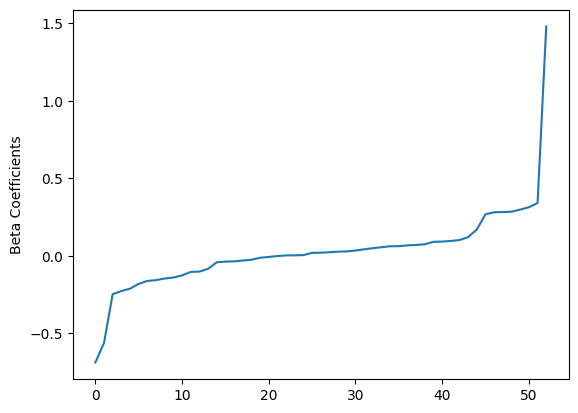

In [58]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

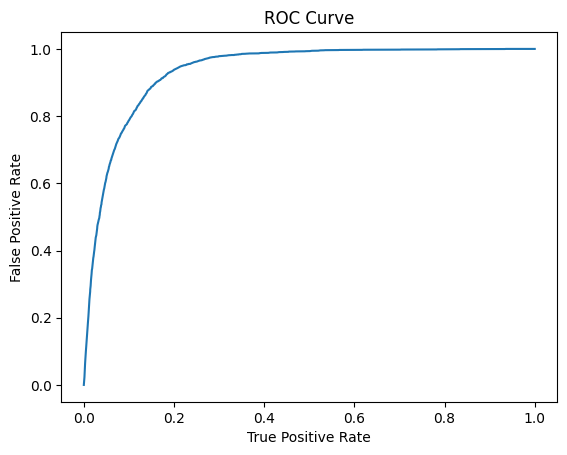

Training set areaUnderROC: 0.9354465492113851


In [59]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

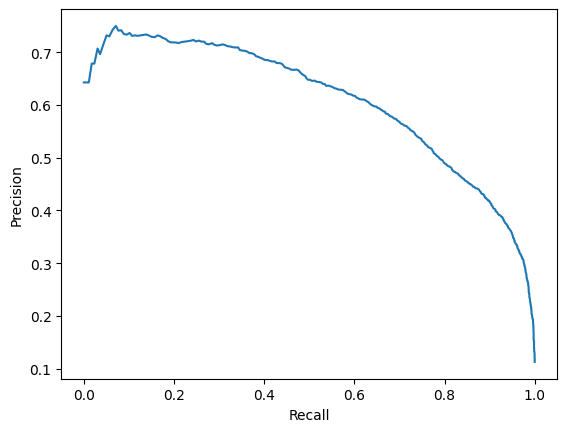

In [60]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [61]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------+-----+--------------------+----------+--------------------+
|age|   job|label|       rawPrediction|prediction|         probability|
+---+------+-----+--------------------+----------+--------------------+
| 25|admin.|  0.0|[4.42251313487497...|       0.0|[0.98813836082501...|
| 39|admin.|  0.0|[4.20723929131180...|       0.0|[0.98533097238573...|
| 51|admin.|  0.0|[3.76025367024174...|       0.0|[0.97725169651698...|
| 53|admin.|  0.0|[5.40688515498771...|       0.0|[0.99553444027917...|
| 33|admin.|  0.0|[3.46774054766678...|       0.0|[0.96975582026660...|
| 38|admin.|  0.0|[4.19937160228282...|       0.0|[0.98521681871102...|
| 42|admin.|  0.0|[4.22559890678943...|       0.0|[0.98559398847308...|
| 24|admin.|  0.0|[2.57472209603796...|       0.0|[0.92921691179043...|
| 29|admin.|  0.0|[4.29130145916180...|       0.0|[0.98649770674630...|
| 29|admin.|  0.0|[4.54828253929079...|       0.0|[0.98952550762807...|
+---+------+-----+--------------------+----------+--------------

In [62]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Logistic Regression Area Under ROC', evaluator.evaluate(predictions))

Logistic Regression Area Under ROC 0.9315687003748468


## Decision Tree

In [63]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------+-----+---------------+----------+--------------------+
|age|   job|label|  rawPrediction|prediction|         probability|
+---+------+-----+---------------+----------+--------------------+
| 25|admin.|  0.0|[22087.0,616.0]|       0.0|[0.97286702197947...|
| 39|admin.|  0.0|[22087.0,616.0]|       0.0|[0.97286702197947...|
| 51|admin.|  0.0|[22087.0,616.0]|       0.0|[0.97286702197947...|
| 53|admin.|  0.0|[22087.0,616.0]|       0.0|[0.97286702197947...|
| 33|admin.|  0.0|[22087.0,616.0]|       0.0|[0.97286702197947...|
| 38|admin.|  0.0|[22087.0,616.0]|       0.0|[0.97286702197947...|
| 42|admin.|  0.0|[22087.0,616.0]|       0.0|[0.97286702197947...|
| 24|admin.|  0.0|[22087.0,616.0]|       0.0|[0.97286702197947...|
| 29|admin.|  0.0|[22087.0,616.0]|       0.0|[0.97286702197947...|
| 29|admin.|  0.0|[22087.0,616.0]|       0.0|[0.97286702197947...|
+---+------+-----+---------------+----------+--------------------+
only showing top 10 rows



In [64]:
evaluator = BinaryClassificationEvaluator()
print("Decision Tree Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Decision Tree Area Under ROC: 0.5398457275896701


## Random Forest

In [65]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------+-----+--------------------+----------+--------------------+
|age|   job|label|       rawPrediction|prediction|         probability|
+---+------+-----+--------------------+----------+--------------------+
| 25|admin.|  0.0|[19.1318272295633...|       0.0|[0.95659136147816...|
| 39|admin.|  0.0|[19.1318272295633...|       0.0|[0.95659136147816...|
| 51|admin.|  0.0|[19.1318272295633...|       0.0|[0.95659136147816...|
| 53|admin.|  0.0|[19.1318272295633...|       0.0|[0.95659136147816...|
| 33|admin.|  0.0|[19.1318272295633...|       0.0|[0.95659136147816...|
| 38|admin.|  0.0|[19.1318272295633...|       0.0|[0.95659136147816...|
| 42|admin.|  0.0|[19.1318272295633...|       0.0|[0.95659136147816...|
| 24|admin.|  0.0|[19.1162971755169...|       0.0|[0.95581485877584...|
| 29|admin.|  0.0|[19.1162971755169...|       0.0|[0.95581485877584...|
| 29|admin.|  0.0|[19.1162971755169...|       0.0|[0.95581485877584...|
+---+------+-----+--------------------+----------+--------------

In [66]:
evaluator = BinaryClassificationEvaluator()
print("Random Forest Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Random Forest Area Under ROC: 0.9237488427214937


## Gradient-Boosted Tree

In [67]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+------+-----+--------------------+----------+--------------------+
|age|   job|label|       rawPrediction|prediction|         probability|
+---+------+-----+--------------------+----------+--------------------+
| 25|admin.|  0.0|[1.31208482975854...|       0.0|[0.93240099179956...|
| 39|admin.|  0.0|[1.31208482975854...|       0.0|[0.93240099179956...|
| 51|admin.|  0.0|[1.31208482975854...|       0.0|[0.93240099179956...|
| 53|admin.|  0.0|[1.31208482975854...|       0.0|[0.93240099179956...|
| 33|admin.|  0.0|[1.31208482975854...|       0.0|[0.93240099179956...|
| 38|admin.|  0.0|[1.31208482975854...|       0.0|[0.93240099179956...|
| 42|admin.|  0.0|[1.31208482975854...|       0.0|[0.93240099179956...|
| 24|admin.|  0.0|[1.17899085583336...|       0.0|[0.91356656899023...|
| 29|admin.|  0.0|[1.31208482975854...|       0.0|[0.93240099179956...|
| 29|admin.|  0.0|[1.31208482975854...|       0.0|[0.93240099179956...|
+---+------+-----+--------------------+----------+--------------

In [68]:
evaluator = BinaryClassificationEvaluator()
print("Gradient-Boosted Tree Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Gradient-Boosted Tree Area Under ROC: 0.9410826626943768


In [69]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

## Linear SVM

In [70]:
from pyspark.ml.classification import LinearSVC
lsvc = LinearSVC(labelCol="label", maxIter=10)
lsvc = lsvc.fit(train)

In [71]:
pred = lsvc.transform(test)
pred.select('features','label', 'rawPrediction', 'prediction').show(10)

+--------------------+-----+--------------------+----------+
|            features|label|       rawPrediction|prediction|
+--------------------+-----+--------------------+----------+
|(53,[0,11,14,21,2...|  0.0|[3.10958719407370...|       0.0|
|(53,[0,11,14,21,2...|  0.0|[2.96437637153134...|       0.0|
|(53,[0,11,14,21,2...|  0.0|[2.62955403010346...|       0.0|
|(53,[0,11,14,21,2...|  0.0|[3.66367070412608...|       0.0|
|(53,[0,11,14,21,2...|  0.0|[2.42642497660423...|       0.0|
|(53,[0,11,14,21,2...|  0.0|[3.00510741035753...|       0.0|
|(53,[0,11,14,21,2...|  0.0|[3.03890885600176...|       0.0|
|(53,[0,11,14,21,2...|  0.0|[1.65186720684602...|       0.0|
|(53,[0,11,14,21,2...|  0.0|[3.05861314549974...|       0.0|
|(53,[0,11,14,21,2...|  0.0|[3.19119321871043...|       0.0|
+--------------------+-----+--------------------+----------+
only showing top 10 rows



In [72]:
print("Linear SVM Area Under ROC: " + str(evaluator.evaluate(pred, {evaluator.metricName: "areaUnderROC"})))

Linear SVM Area Under ROC: 0.9304815763092932


In [73]:
# lr = pipeline.fit(df) // Trained model
# lr.save("/path")
# pipelineModel = lr.load("/path")
# df = pipelineModel.transform(df)

# gbtModel = gbt.fit(train)


In [90]:
import joblib
# fileName = "gbtModel.joblib"
# joblib.dump(gbtModel, "./" + fileName)

In [76]:
path = "D:/Libraries/Documents"

In [89]:
# gbtModel.save("D:/Libraries/Documents")
# gbtModel.save(sc,"D:/Libraries/Documents")

In [ ]:
sc

In [88]:
# gbtModel.write().save("D:/Libraries/Documents")

In [82]:
import pickle

In [91]:
# pickle.dump(gbtModel, open('D:/Libraries/Documents/gbtModel.pkl', 'wb'))